In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import PIL
from io import BytesIO
from IPython.display import clear_output, Image as NoteImage, display
from sklearn.model_selection import train_test_split
# from pycaret.regression import setup, compare_models,evaluate_model ,  predict_model,  save_model, load_model

In [4]:
# pip install pycaret[full]

In [4]:
%matplotlib notebook
def imshow(im,fmt='jpeg'):
    #a = np.uint8(np.clip(im, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(im).save(f, fmt)
    display(NoteImage(data=f.getvalue()))
def imread(filename):
    img = cv.imread(filename)

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

In [5]:
data=pd.read_csv("Fall 2019 Plumes detected by AVIRIS-NG and GAO provided by NASA-JPL and U.Arizona.csv")
data

,source_id,plume_lat,plume_lon,plume_candidate_id,date_of_detection,time_of_detection,source_type,source_type_label,ipcc,qplume,sigma_qplume,active_flare,inactive_flare,Operator_Alias,imageurl
0,P00156,32.283447,-103.741815,ang20190922t192642-A,9/23/2019,7:26:42 PM,compressor,Midstream,1B2 Oil & Natural Gas,296.676732,98.755811,False,False,DCP MIDSTREAM PARTNERS,https://edf-permian-data.s3.amazonaws.com/imag...
1,P00119,32.244361,-103.711379,ang20190922t192642-B,9/23/2019,7:26:42 PM,tank,Production,1B2 Oil & Natural Gas,640.968143,190.138173,False,False,DEVON ENERGY PRODUCTION CO,https://edf-permian-data.s3.amazonaws.com/imag...
2,P00475,32.166625,-103.685468,ang20190922t194340-A,9/23/2019,7:43:40 PM,tank,Production,1B2 Oil & Natural Gas,1091.242729,310.028504,False,False,DEVON ENERGY PRODUCTION CO,https://edf-permian-data.s3.amazonaws.com/imag...
3,P00002,32.200072,-103.673301,ang20190922t192642-4,9/23/2019,7:26:42 PM,tank,Production,1B2 Oil & Natural Gas,420.725207,147.155782,False,False,ENLINK,https://edf-permian-data.s3.amazonaws.com/imag...
4,P00003,32.116008,-103.626345,ang20190922t192642-5,9/23/2019,7:26:42 PM,tank,Production,1B2 Oil & Natural Gas,1051.909600,339.267587,False,False,EOG RESOURCES INC,https://edf-permian-data.s3.amazonaws.com/imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3062,P01769,31.478768,-102.958800,GAO20191103t163539p0000-C,11/4/2019,4:35:39 PM,compressor,Midstream,1B2 Oil & Natural Gas,159.291858,64.873698,False,False,UNKNOWN,https://edf-permian-data.s3.amazonaws.com/imag...
3063,P01784,32.793745,-104.123650,GAO20191103t181042p0000-A,11/4/2019,6:10:42 PM,pipeline,Midstream,1B2 Oil & Natural Gas,250.722494,51.888206,False,False,UNKNOWN,https://edf-permian-data.s3.amazonaws.com/imag...
3064,P01784,32.793674,-104.123290,GAO20191103t182306p0000-B,11/4/2019,6:23:06 PM,pipeline,Midstream,1B2 Oil & Natural Gas,298.184474,68.096895,False,False,UNKNOWN,https://edf-permian-data.s3.amazonaws.com/imag...
3065,P01786,32.795682,-104.163570,GAO20191103t182306p0000-C,11/4/2019,6:23:06 PM,pipeline,Midstream,1B2 Oil & Natural Gas,200.567906,36.274204,False,False,UNKNOWN,https://edf-permian-data.s3.amazonaws.com/imag...


In [6]:
def flare_extractor(img):
#     img=imread("ang20190922t192642-A.png")
    x,y,c=img.shape
    real_img=np.zeros((x,y,c))
    red=img[:,:,0]
    green=img[:,:,1]
    blue=img[:,:,2]
    only_blue_carbon=np.uint8(blue>220)*np.uint8(green<120)*np.uint8(red<120)
    only_blue_carbon_sum=np.sum(only_blue_carbon)
#     imshow(only_blue_carbon)
    only_green_carbon=np.uint8(blue<150)*np.uint8(green>150)*np.uint8(red<150)
#     imshow(only_green_carbon)
    only_green_carbon_sum=np.sum(only_green_carbon)
    only_red_carbon=np.uint8(blue<120)*np.uint8(green<120)*np.uint8(red>220)
    only_red_carbon_sum=np.sum(only_red_carbon)
    only_yellow_carbon=np.uint8(blue<120)*np.uint8(green>220)*np.uint8(red>220)*255

#     imshow(only_red_carbon)
    real_img[:,:,0]=only_red_carbon*255
    real_img[:,:,1]=only_green_carbon*255
    real_img[:,:,2]=only_blue_carbon*255
    # real_img[:,:,0]=only_red_carbon+only_yellow_carbon
    # real_img[:,:,0]=only_green_carbon+only_yellow_carbon
    out=np.uint8(real_img)
    # imshow(out)
    # print(out)
    return out,only_red_carbon_sum, only_green_carbon_sum, only_blue_carbon_sum

In [7]:
def flare_extractor(img):
#     img=imread("ang20190922t192642-A.png")
    x,y,c=img.shape
    real_img=np.zeros((x,y,c))
    red=img[:,:,0]
    green=img[:,:,1]
    blue=img[:,:,2]
    only_blue_carbon=np.uint8(blue>150)*np.uint8(green<120)*np.uint8(red<120)
    only_blue_carbon_sum=np.sum(only_blue_carbon)
#     imshow(only_blue_carbon)
    only_green_carbon=np.uint8(blue<120)*np.uint8(green>150)*np.uint8(red<120)
#     imshow(only_green_carbon)
    only_green_carbon_sum=np.sum(only_green_carbon)
    only_red_carbon=np.uint8(blue<120)*np.uint8(green<120)*np.uint8(red>150)
    only_red_carbon_sum=np.sum(only_red_carbon)
    only_yellow_carbon=np.uint8(blue<120)*np.uint8(green>180)*np.uint8(red>180)
    only_yellow_carbon_sum=np.sum(only_yellow_carbon)
#     imshow(only_red_carbon)
#     real_img[:,:,0]=only_red_carbon*255
    
#     real_img[:,:,1]=only_green_carbon*255
#     real_img[:,:,2]=only_blue_carbon*255
    real_img[:,:,0]=np.logical_xor(only_red_carbon,only_yellow_carbon)*255

    real_img[:,:,1]=np.logical_xor(only_green_carbon,only_yellow_carbon)*255
    real_img[:,:,2]=only_blue_carbon*255
    # real_img[:,:,0]=only_red_carbon+only_yellow_carbon
    # real_img[:,:,0]=only_green_carbon+only_yellow_carbon
    out=np.uint8(real_img)
    # imshow(out)
    # print(out)
    
    return out,only_red_carbon_sum, only_green_carbon_sum, only_blue_carbon_sum,only_yellow_carbon_sum

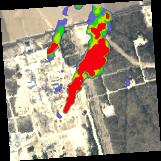

In [8]:
image=imread("images/processing-87.png")
imshow(image)

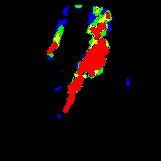

In [9]:
extracted_image,r,g,b,y=flare_extractor(image)
imshow(extracted_image)

In [10]:
df=pd.DataFrame(data,columns=["source_type","qplume"])

In [10]:
data["red"]=1
data["green"]=1
data["blue"]=1
data["yellow"]=1
data["source_type"]=data["source_type"].astype(str)

In [11]:
# data["img"]=data["source_type"].apply(lambda row: imread("images/"+row+"-"+row.name+".png"))
for i in range(len(data)):
    try:
        img=imread("images/"+data["source_type"][i]+"-"+str(i)+".png")
        # imshow(img)

        img,r,g,b,y=flare_extractor(img)
        
        # data["img"][i]=img
        data["red"][i]=r
        data["green"][i]=g
        data["blue"][i]=b
        data["yellow"][i]=y
        # data["img"][i]=img
    except:
        print("error at "+str(i))
        pass
   
# img=imread(data["source_type"][0]+"-"+str(0)+".png")

/tmp/ipykernel_5525/312141479.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["red"][i]=r
/tmp/ipykernel_5525/312141479.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["green"][i]=g
/tmp/ipykernel_5525/312141479.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["blue"][i]=b
/tmp/ipykernel_5525/312141479.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

error at 1080


In [17]:
df=data[["source_type","qplume","red","green","blue","yellow"]]
dummy=pd.get_dummies(df,columns=["source_type"],drop_first=True)
dummy.to_csv("dummys_2.0.csv",index=False)

KeyError: "['source_type'] not in index"

# Testing on obtained data


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import PIL
from io import BytesIO
from IPython.display import clear_output, Image as NoteImage, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error 
# from pycaret.regression import setup, compare_models,evaluate_model ,  predict_model,  save_model, load_model

In [2]:
data=pd.read_csv("dummys_2.0.csv")

In [3]:
data.head()

,qplume,red,green,blue,yellow,source_type_nan,source_type_pipeline,source_type_processing,source_type_tank,source_type_well
0,296.676732,0,9,226,1,0,0,0,0,0
1,640.968143,12,13,51,1,0,0,0,1,0
2,1091.242729,174,72,39,17,0,0,0,1,0
3,420.725207,23,30,74,11,0,0,0,1,0
4,1051.909600,119,44,129,1,0,0,0,1,0


In [4]:
df=data[data["source_type_nan"]!=1].drop(labels="source_type_nan",axis=1)[["qplume","red","green","blue","yellow"]]
df.head()

,qplume,red,green,blue,yellow
0,296.676732,0,9,226,1
1,640.968143,12,13,51,1
2,1091.242729,174,72,39,17
3,420.725207,23,30,74,11
4,1051.909600,119,44,129,1


/home/panda/anaconda3/envs/carbon_detector/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


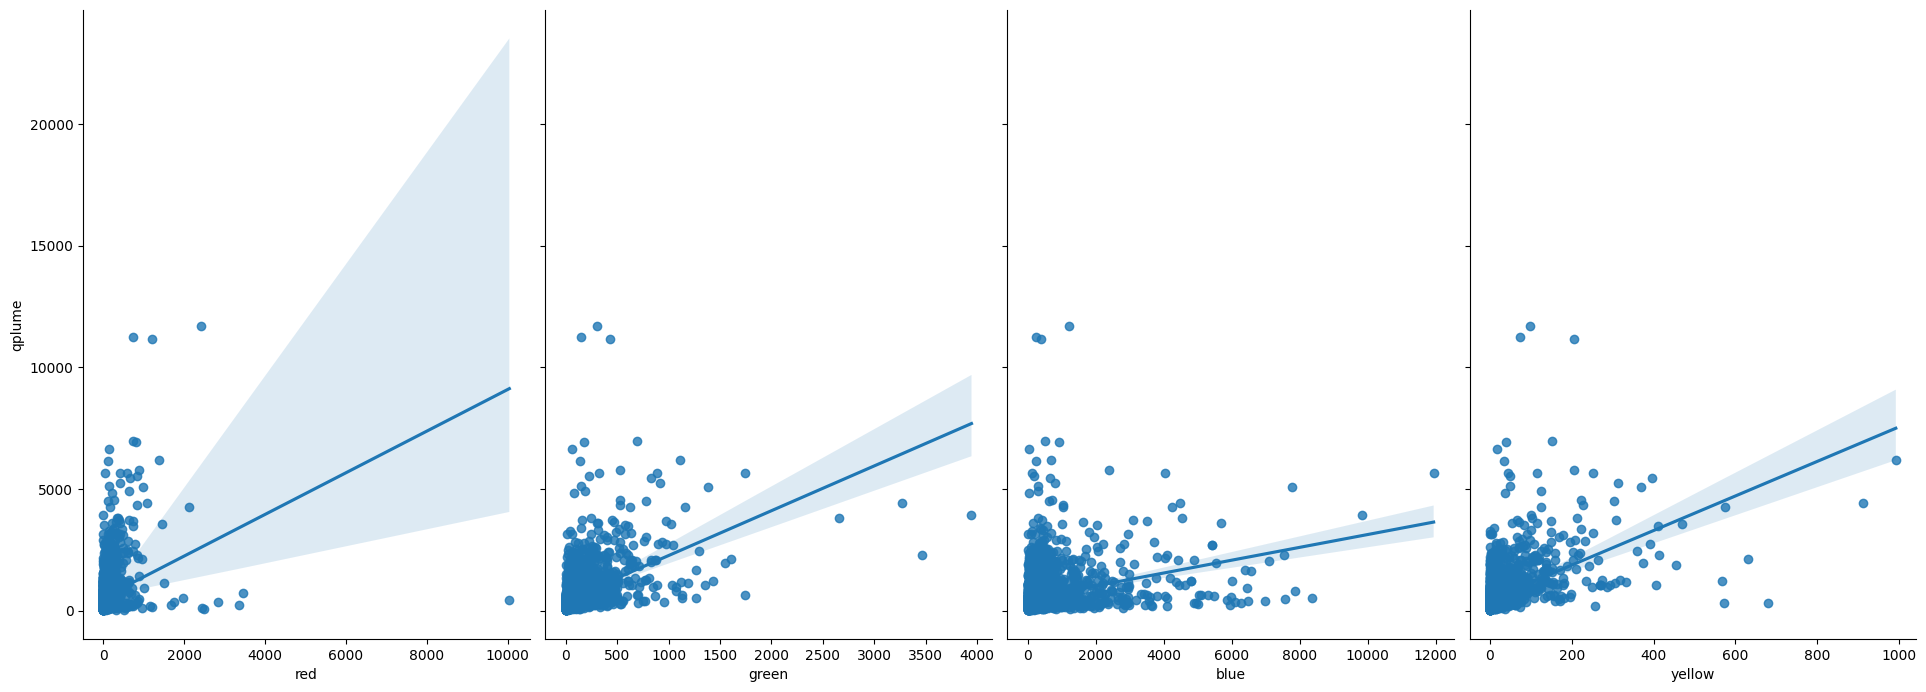

In [5]:
%matplotlib inline
import seaborn as sns
sns.pairplot(df, x_vars=['red', 'green', 'blue', 'yellow'], y_vars='qplume', size=7, aspect=0.7, kind='reg')

In [6]:
X=df.drop(labels="qplume",axis=1)
y=df["qplume"]
X_train, X_test,y_train, y_test = train_test_split(X,y ,random_state=42,test_size=0.25, shuffle=True)

In [27]:
model=LinearRegression()
model.fit(X_train,y_train)
# output=model.score(X_test,y_test)
# output
y_pred_train=model.predict(X_train)
output_train=np.sqrt(mean_squared_error(y_train,y_pred_train))
y_pred=model.predict(X_test)
output=np.sqrt(mean_squared_error(y_test,y_pred))

output_train,output

(634.5223166569019, 665.5529590796579)

In [ ]:
from sklearn.preprocessing import normal

In [8]:
print(f"intercept: {model.intercept_}")

print(f"slope: {model.coef_}")


intercept: 387.118662529246
slope: [0.40466603 0.97224216 0.02109442 3.58749474]


In [9]:
output_without_bias=model.predict(X_test)-model.predict([[0,0,0,0]])
# mean_squared_error(y_test,output_without_bias)

/home/panda/anaconda3/envs/carbon_detector/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [10]:
coefficients = np.random.randn(len(X_train.iloc[0]))
# Set the learning rate
learning_rate = 0.0001

# Set the number of iterations
n_iterations = 10000

# Loop through the number of iterations
for i in range(n_iterations):
    # Make a prediction using the current coefficients
    y_pred = np.dot(X_train, coefficients)

    # Calculate the error between the true labels and the predictions
    error = y_pred - y_train

    # Calculate the gradient of the error
    gradient =  np.dot(X_train.T, error) / (len(X_train)*n_iterations)

    # Update the coefficients
    coefficients = coefficients - learning_rate * gradient
    print(coefficients) 

# Print the final coefficients
print(coefficients)





[-0.18257726  1.27538761  0.24835345 -0.21523173]
[-0.1817712   1.27574036  0.24849802 -0.21506983]
[-0.18096598  1.27609257  0.24864036 -0.21490805]
[-0.18016159  1.27644425  0.24878049 -0.21474638]
[-0.17935804  1.2767954   0.24891845 -0.21458484]
[-0.17855532  1.27714601  0.24905424 -0.21442341]
[-0.17775343  1.27749611  0.24918789 -0.2142621 ]
[-0.17695236  1.27784568  0.24931943 -0.2141009 ]
[-0.17615212  1.27819474  0.24944886 -0.21393983]
[-0.17535271  1.27854328  0.24957621 -0.21377886]
[-0.17455411  1.27889132  0.24970151 -0.21361802]
[-0.17375634  1.27923885  0.24982476 -0.21345728]
[-0.17295938  1.27958587  0.24994598 -0.21329666]
[-0.17216324  1.27993239  0.25006521 -0.21313616]
[-0.17136792  1.28027842  0.25018245 -0.21297576]
[-0.17057341  1.28062395  0.25029773 -0.21281548]
[-0.16977971  1.280969    0.25041105 -0.21265531]
[-0.16898682  1.28131356  0.25052246 -0.21249525]
[-0.16819474  1.28165763  0.25063195 -0.2123353 ]
[-0.16740347  1.28200122  0.25073954 -0.21217546]


In [11]:
# Make a prediction using the obtained coefficients
prediction = np.dot(X_test, coefficients)
print(mean_squared_error(y_test,prediction))
# print(prediction)

603010.6630837738


In [14]:
# df["red"]=data.apply(lambda row: imread("images/"+row["source_type"]+"-"+row.index+".png"))

In [18]:
class LinearRegression:
    def __init__(self, learning_rate=1e-5, n_iters=1000):
        # init parameters
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = 0
        # self.bias = None
    
    def _init_params(self):
        self.weights = np.random.randn(4).reshape(1, -1).T
        # self.bias = 0
    
    def _update_params(self, dw):
        self.weights -= self.lr * dw
        # self.bias -= self.lr * db
    
    def _get_prediction(self, X):
        return np.dot(X, self.weights) #+ self.bias
    
    def _get_gradients(self, X, y, y_pred):
        # get distance between y_pred and y_true
        error = y_pred - y[:, np.newaxis]
        # print(y_pred.shape,y[:, np.newaxis].shape)
        # compute the gradients of weight & bias
        dw = (1 / (self.n_samples)) * np.dot(X.T, error)
        #db = (1 / self.n_samples) * np.sum(error)
        return dw #, db
    
    def fit(self, X, y):
        # get number of samples & features
        self.n_samples, self.n_features = X.shape
        # init weights & bias
        self._init_params()

        # perform gradient descent for n iterations
        for _ in range(self.n_iters):
            # get y_prediction
            y_pred = self._get_prediction(X)
            # compute gradients
            dw = self._get_gradients(X, y, y_pred)
            # update weights & bias with gradients

            print(self.weights)
            self._update_params(dw )
    
    def predict(self, X):
        y_pred = self._get_prediction(X)
        return y_pred

In [19]:
# define helper function to evaluate 
def rmse(y_true, y_pred):

    return np.sqrt(np.mean((y_pred - y_true[:, np.newaxis])**2))


# instantiate regressor and fit
linreg = LinearRegression(learning_rate=0.01, n_iters=1000)
linreg.fit(X_train, y_train)

# make prediction
predictions = linreg.predict(X_test)
print(f"RMSE: {rmse(y_test, predictions)}")

/tmp/ipykernel_20524/1174085793.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  error = y_pred - y[:, np.newaxis]


[[-0.95235066]
 [ 1.51578312]
 [-1.23394891]
 [ 1.09311672]]
[[ 1.10719811]
 [ 3.94002073]
 [11.77543258]
 [ 1.58018467]]
[[ -5.2604197 ]
 [-14.28514837]
 [-95.38879286]
 [ -1.39626256]]
[[ 48.27135646]
 [134.76946347]
 [779.52459701]
 [ 23.3572457 ]]
[[ -388.63505331]
 [-1082.32969171]
 [-6364.69407557]
 [ -178.41114382]]
[[ 3178.9854351 ]
 [ 8855.99137039]
 [51972.12436998]
 [ 1469.48694876]]
[[ -25952.78226519]
 [ -72296.39185268]
 [-424382.94741555]
 [ -11986.25919309]]
[[ 211925.54073315]
 [ 590361.38461485]
 [3465341.57616445]
 [  97888.29067325]]
[[ -1730493.47972362]
 [ -4820636.3822647 ]
 [-28296589.31591214]
 [  -799302.91420959]]
[[1.41305214e+07]
 [3.93634018e+07]
 [2.31058604e+08]
 [6.52680105e+06]]
[[-1.15384167e+08]
 [-3.21425739e+08]
 [-1.88673191e+09]
 [-5.32952263e+07]]
[[9.42180850e+08]
 [2.62463373e+09]
 [1.54062963e+10]
 [4.35187464e+08]]
[[-7.69347105e+09]
 [-2.14317067e+10]
 [-1.25801639e+11]
 [-3.55356633e+09]]
[[6.28217999e+10]
 [1.75002724e+11]
 [1.02724574e+1

/tmp/ipykernel_20524/1705837544.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.sqrt(np.mean((y_pred - y_true[:, np.newaxis])**2))


In [82]:
np.random.randn(4).reshape(1, -1)

array([[1.12765254, 1.4797657 , 1.27729973, 1.33461236]])

In [85]:
# print coefficients
# print(f"Intercept: {linreg.bias}")
print(f"Coef: {linreg.weights}")
print((linreg.weights.shape))

Coef: [nan nan nan nan]
(4,)


In [13]:
# def rotate_image(image, angle):
#   image_center = tuple(np.array(image.shape[1::-1]) / 2)
#   rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
#   result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
#   return result
# y=28
# x=28
# h=155
# w=155  
# imshow(rotate_image(img,30))

In [17]:
np.hstack()

ValueError: Length of values (123) does not match length of index (3067)